In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.preprocessing import LabelEncoder

import pingouin as pg
from sklearn.covariance import GraphicalLassoCV
import scipy.stats as stats



In [10]:
# Load Dataset
df = pd.read_csv("data.csv")
df = df.drop(columns=["Interest"])

cols_all = ["Age", "Gender", "Education", "Introversion Score", "Sensing Score", "Thinking Score", "Judging Score"]
mbti_cols = ["Introversion Score", "Sensing Score", "Thinking Score", "Judging Score"]


df_encoded = df.copy()
categorical_cols = ["Gender", "Education"]

for col in df.columns:
    if df[col].dtype == object:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df[col].astype(str))

print(df_encoded.shape)
print(df_encoded.dtypes)

(43744, 8)
Age                   float64
Gender                  int64
Education               int64
Introversion Score    float64
Sensing Score         float64
Thinking Score        float64
Judging Score         float64
Personality             int64
dtype: object


## 1. Pearson Correlation

Check for linear relationships (positive or negative correlations).
If the value is close to zero, it indicates little to no linear correlation.

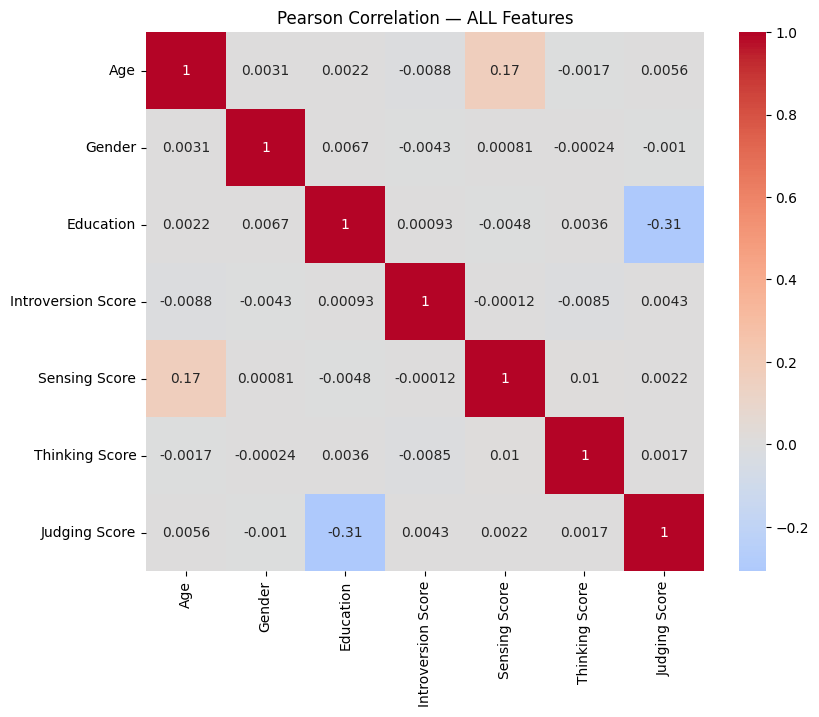


Pearson Correlation Table — ALL Features:
                         Age    Gender  Education  Introversion Score  \
Age                 1.000000  0.003122   0.002236           -0.008814   
Gender              0.003122  1.000000   0.006691           -0.004294   
Education           0.002236  0.006691   1.000000            0.000930   
Introversion Score -0.008814 -0.004294   0.000930            1.000000   
Sensing Score       0.166563  0.000808  -0.004769           -0.000116   
Thinking Score     -0.001742 -0.000238   0.003562           -0.008502   
Judging Score       0.005590 -0.001030  -0.307034            0.004279   

                    Sensing Score  Thinking Score  Judging Score  
Age                      0.166563       -0.001742       0.005590  
Gender                   0.000808       -0.000238      -0.001030  
Education               -0.004769        0.003562      -0.307034  
Introversion Score      -0.000116       -0.008502       0.004279  
Sensing Score            1.000000    

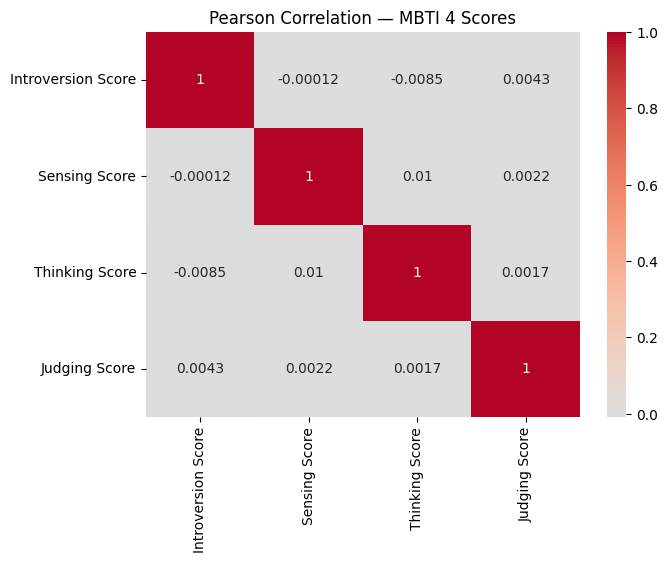


Pearson Correlation Table — MBTI 4 Scores:
                    Introversion Score  Sensing Score  Thinking Score  \
Introversion Score            1.000000      -0.000116       -0.008502   
Sensing Score                -0.000116       1.000000        0.010325   
Thinking Score               -0.008502       0.010325        1.000000   
Judging Score                 0.004279       0.002179        0.001714   

                    Judging Score  
Introversion Score       0.004279  
Sensing Score            0.002179  
Thinking Score           0.001714  
Judging Score            1.000000  


In [11]:
pearson_all = df_encoded[cols_all].corr()

plt.figure(figsize=(9,7))
sns.heatmap(pearson_all, annot=True, cmap="coolwarm", center=0)
plt.title("Pearson Correlation — ALL Features")
plt.show()

print("\nPearson Correlation Table — ALL Features:")
print(pearson_all)


pearson_mbti = df_encoded[mbti_cols].corr()

plt.figure(figsize=(7,5))
sns.heatmap(pearson_mbti, annot=True, cmap="coolwarm", center=0)
plt.title("Pearson Correlation — MBTI 4 Scores")
plt.show()

print("\nPearson Correlation Table — MBTI 4 Scores:")
print(pearson_mbti)

## Mutual Information

Capture dependencies of any form, including nonlinear relationships.
MI values close to zero indicate near independence.

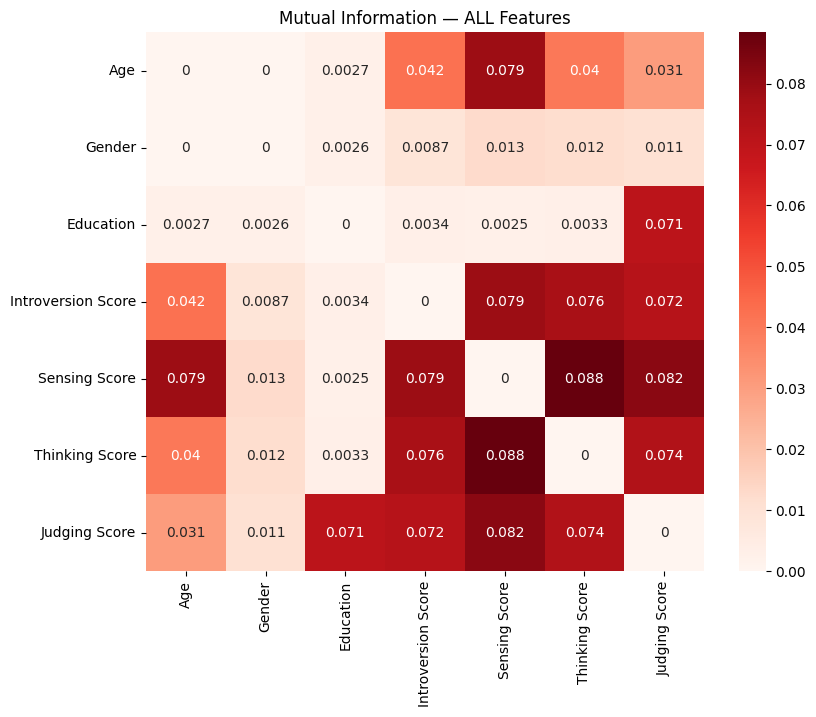


Mutual Information Table — ALL Features:
                         Age    Gender  Education  Introversion Score  \
Age                 0.000000  0.000000   0.002670            0.042412   
Gender              0.000000  0.000000   0.002581            0.008720   
Education           0.002670  0.002581   0.000000            0.003392   
Introversion Score  0.042412  0.008720   0.003392            0.000000   
Sensing Score       0.078752  0.012704   0.002540            0.078957   
Thinking Score      0.040145  0.011857   0.003268            0.076265   
Judging Score       0.030659  0.010977   0.070990            0.072498   

                    Sensing Score  Thinking Score  Judging Score  
Age                      0.078752        0.040145       0.030659  
Gender                   0.012704        0.011857       0.010977  
Education                0.002540        0.003268       0.070990  
Introversion Score       0.078957        0.076265       0.072498  
Sensing Score            0.000000     

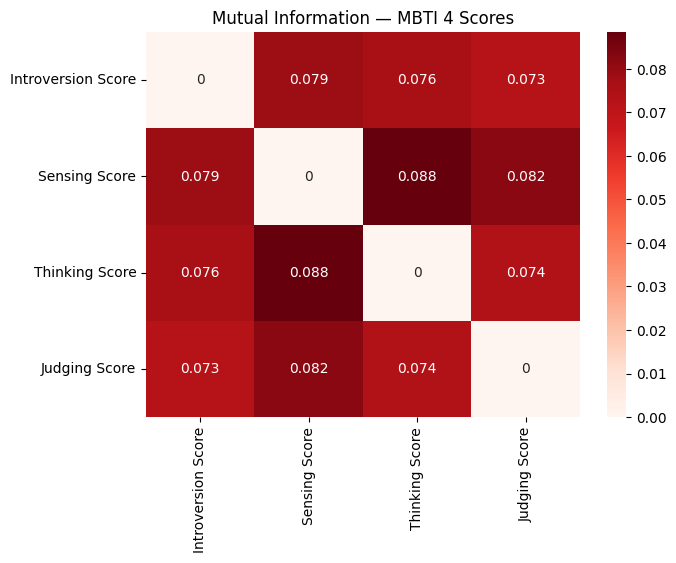


Mutual Information Table — MBTI 4 Scores:
                    Introversion Score  Sensing Score  Thinking Score  \
Introversion Score            0.000000       0.078927        0.076301   
Sensing Score                 0.078927       0.000000        0.088458   
Thinking Score                0.076301       0.088458        0.000000   
Judging Score                 0.072509       0.082182        0.073855   

                    Judging Score  
Introversion Score       0.072509  
Sensing Score            0.082182  
Thinking Score           0.073855  
Judging Score            0.000000  


In [12]:
def compute_mi_matrix(df_enc, cols, categorical_cols):
    n = len(cols)
    MI = pd.DataFrame(np.zeros((n, n)), index=cols, columns=cols)

    for i, ci in enumerate(cols):
        for j, cj in enumerate(cols):
            if i == j:
                MI.loc[ci, cj] = 0
                continue
            
            X = df_enc[[ci]].values
            y = df_enc[cj].values

            if cj in categorical_cols: # If target is categorical
                mi = mutual_info_classif(X, y, discrete_features="auto")[0]
            else:
                mi = mutual_info_regression(X, y, discrete_features="auto")[0]

            MI.loc[ci, cj] = mi

    # symmetrize
    MI = (MI + MI.T) / 2
    return MI


mi_all = compute_mi_matrix(df_encoded, cols_all, categorical_cols)

plt.figure(figsize=(9,7))
sns.heatmap(mi_all, annot=True, cmap="Reds")
plt.title("Mutual Information — ALL Features")
plt.show()

print("\nMutual Information Table — ALL Features:")
print(mi_all)


mi_mbti = compute_mi_matrix(df_encoded, mbti_cols, categorical_cols)

plt.figure(figsize=(7,5))
sns.heatmap(mi_mbti, annot=True, cmap="Reds")
plt.title("Mutual Information — MBTI 4 Scores")
plt.show()

print("\nMutual Information Table — MBTI 4 Scores:")
print(mi_mbti)

## Partial Correlation

Remove the effects of confounding variables to reveal “pure” pairwise relationships.
After controlling for the other two dimensions, do the remaining pair still exhibit correlation?

In [13]:
def compute_partial_corr_matrix(df, cols):
    """
    Compute partial correlation matrix for a list of columns.
    """
    n = len(cols)
    mat = pd.DataFrame(np.zeros((n, n)), index=cols, columns=cols)

    for i, ci in enumerate(cols):
        for j, cj in enumerate(cols):
            if i == j:
                mat.loc[ci, cj] = 1.0   # diagonal = 1
                continue

            # Z =  set of all other variables
            control_vars = list(set(cols) - {ci, cj})

            res = pg.partial_corr(
                data=df,
                x=ci,
                y=cj,
                covar=control_vars,
                method='pearson'
            )

            mat.loc[ci, cj] = res['r'].values[0]

    return mat

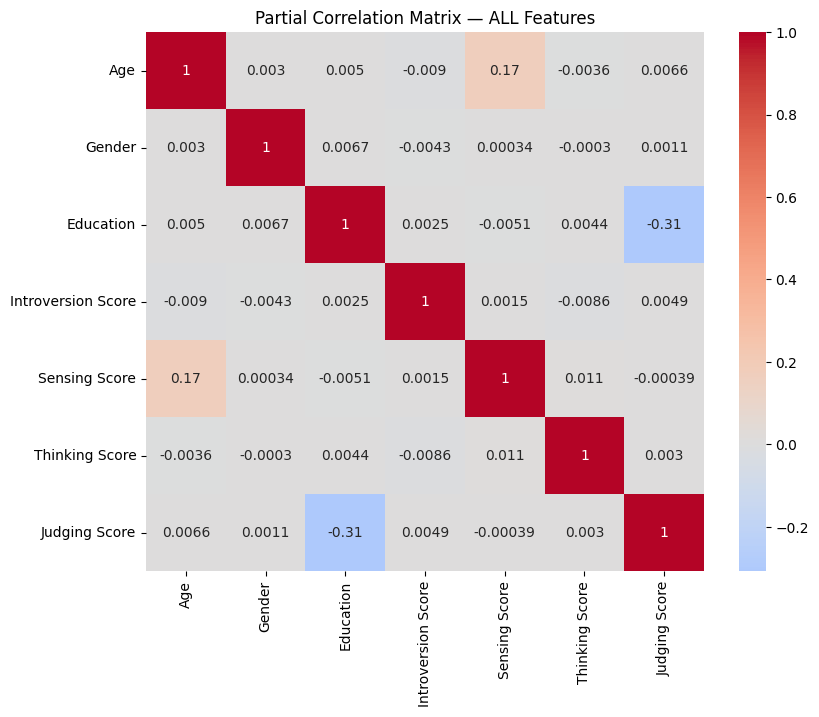


Partial Correlation Table — ALL Features:
                         Age    Gender  Education  Introversion Score  \
Age                 1.000000  0.002963   0.004956           -0.008972   
Gender              0.002963  1.000000   0.006699           -0.004281   
Education           0.004956  0.006699   1.000000            0.002467   
Introversion Score -0.008972 -0.004281   0.002467            1.000000   
Sensing Score       0.166606  0.000336  -0.005123            0.001471   
Thinking Score     -0.003617 -0.000299   0.004381           -0.008552   
Judging Score       0.006612  0.001078  -0.307066            0.004885   

                    Sensing Score  Thinking Score  Judging Score  
Age                      0.166606       -0.003617       0.006612  
Gender                   0.000336       -0.000299       0.001078  
Education               -0.005123        0.004381      -0.307066  
Introversion Score       0.001471       -0.008552       0.004885  
Sensing Score            1.000000    

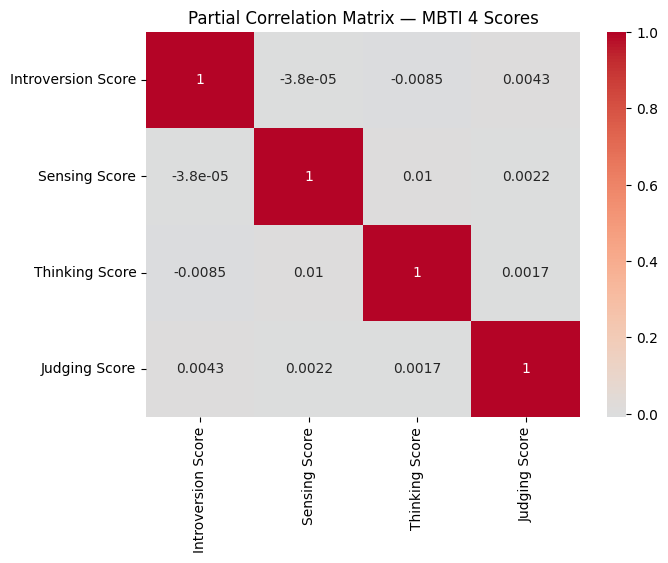


Partial Correlation Table — MBTI 4 Scores:
                    Introversion Score  Sensing Score  Thinking Score  \
Introversion Score            1.000000      -0.000038       -0.008508   
Sensing Score                -0.000038       1.000000        0.010320   
Thinking Score               -0.008508       0.010320        1.000000   
Judging Score                 0.004293       0.002161        0.001728   

                    Judging Score  
Introversion Score       0.004293  
Sensing Score            0.002161  
Thinking Score           0.001728  
Judging Score            1.000000  


In [14]:
partial_all = compute_partial_corr_matrix(df_encoded, cols_all)

plt.figure(figsize=(9,7))
sns.heatmap(partial_all, annot=True, cmap="coolwarm", center=0)
plt.title("Partial Correlation Matrix — ALL Features")
plt.show()

print("\nPartial Correlation Table — ALL Features:")
print(partial_all)


partial_mbti = compute_partial_corr_matrix(df_encoded, mbti_cols)

plt.figure(figsize=(7,5))
sns.heatmap(partial_mbti, annot=True, cmap="coolwarm", center=0)
plt.title("Partial Correlation Matrix — MBTI 4 Scores")
plt.show()

print("\nPartial Correlation Table — MBTI 4 Scores:")
print(partial_mbti)

## Graphical Lasso（Conditional Independence）

Identify the conditional independence network.
Which of the four dimensions are directly related, and which apparent associations are explained by a third variable?

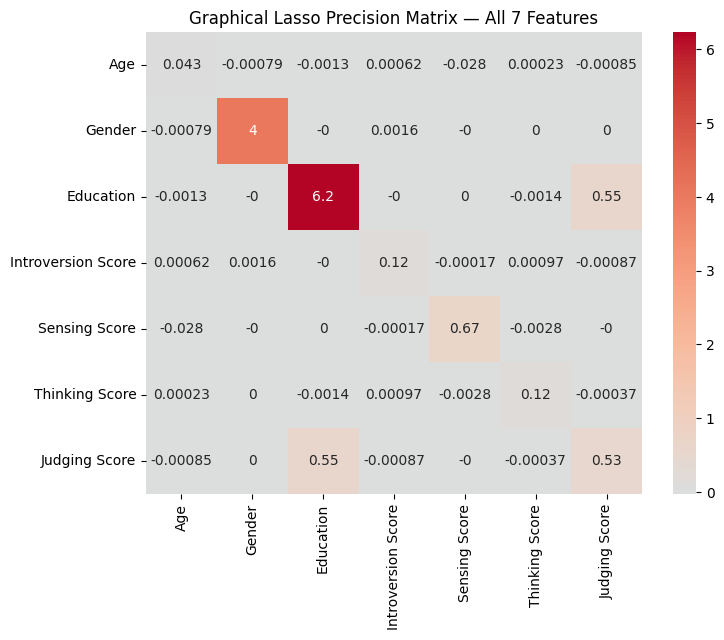

Precision Matrix — All 7 Features:
                         Age    Gender  Education  Introversion Score  \
Age                 0.042945 -0.000787  -0.001283            0.000615   
Gender             -0.000787  4.044097  -0.000000            0.001575   
Education          -0.001283 -0.000000   6.233103           -0.000000   
Introversion Score  0.000615  0.001575  -0.000000            0.118712   
Sensing Score      -0.028115 -0.000000   0.000000           -0.000169   
Thinking Score      0.000232  0.000000  -0.001357            0.000972   
Judging Score      -0.000852  0.000000   0.548881           -0.000870   

                    Sensing Score  Thinking Score  Judging Score  
Age                     -0.028115        0.000232      -0.000852  
Gender                  -0.000000        0.000000       0.000000  
Education                0.000000       -0.001357       0.548881  
Introversion Score      -0.000169        0.000972      -0.000870  
Sensing Score            0.667120       -0.00

In [15]:
X_all = df_encoded[cols_all].values

# Graphical Lasso
model_all = GraphicalLassoCV()
model_all.fit(X_all)

precision_all = model_all.precision_
cov_all = model_all.covariance_

# Precision matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    precision_all,
    annot=True,
    cmap="coolwarm",
    xticklabels=cols_all,
    yticklabels=cols_all,
    center=0
)
plt.title("Graphical Lasso Precision Matrix — All 7 Features")
plt.show()

print("Precision Matrix — All 7 Features:")
print(pd.DataFrame(precision_all, index=cols_all, columns=cols_all))

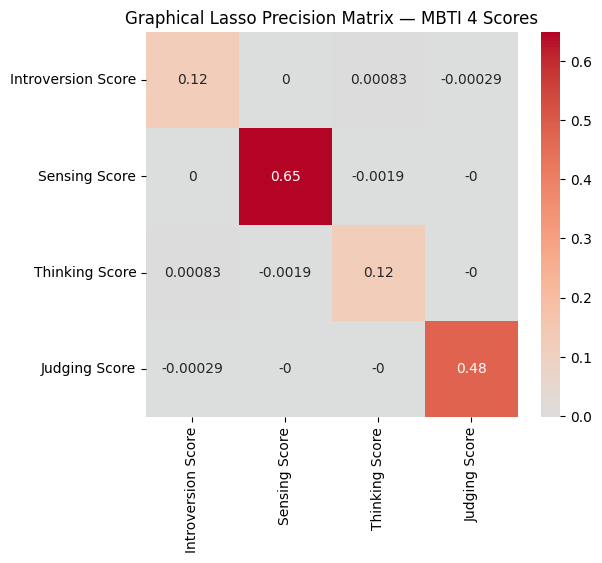

Precision Matrix — MBTI 4 Scores:
                    Introversion Score  Sensing Score  Thinking Score  \
Introversion Score            0.118701       0.000000        0.000829   
Sensing Score                 0.000000       0.648696       -0.001878   
Thinking Score                0.000829      -0.001878        0.118856   
Judging Score                -0.000290      -0.000000       -0.000000   

                    Judging Score  
Introversion Score      -0.000290  
Sensing Score           -0.000000  
Thinking Score          -0.000000  
Judging Score            0.480652  


In [16]:
X_mbti = df_encoded[mbti_cols].values

model_mbti = GraphicalLassoCV()
model_mbti.fit(X_mbti)

precision_mbti = model_mbti.precision_
cov_mbti = model_mbti.covariance_

# Precision matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    precision_mbti,
    annot=True,
    cmap="coolwarm",
    xticklabels=mbti_cols,
    yticklabels=mbti_cols,
    center=0
)
plt.title("Graphical Lasso Precision Matrix — MBTI 4 Scores")
plt.show()

print("Precision Matrix — MBTI 4 Scores:")
print(pd.DataFrame(precision_mbti, index=mbti_cols, columns=mbti_cols))

# Personality Analysis

### Age

In [17]:
pg.anova(data=df, dv='Age', between='Personality')

,Source,ddof1,ddof2,F,p-unc,np2
0,Personality,15,43728,284.056914,0.0,0.088788


The results show that personality type has a highly significant effect on age:

F(15, 43728) = 284.06

p < .001

η² = 0.0888

These findings indicate that age distributions are not uniform across the 16 personality types—some types tend to be associated with younger individuals, whereas others are more prevalent among relatively older age groups.

/var/folders/ky/fwz5mknj2mbf6z6qnf5_sbcc0000gn/T/ipykernel_595/3733604676.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Personality", y="Age", showfliers=False, palette="Set2")


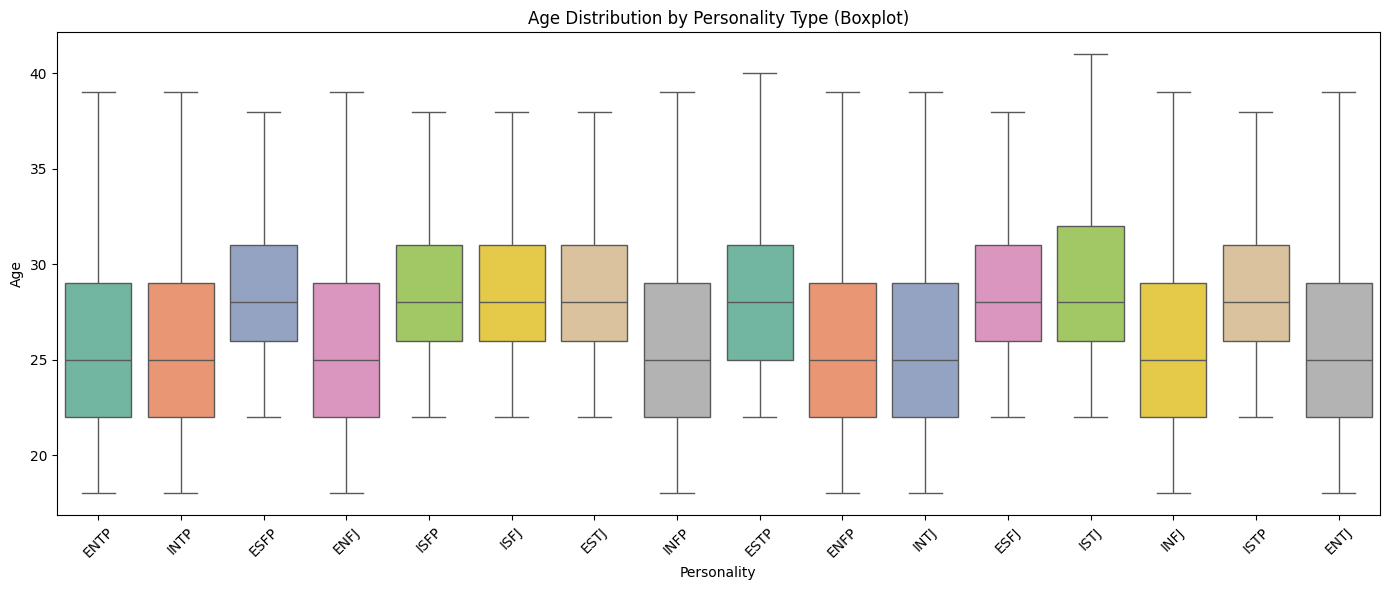

In [18]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="Personality", y="Age", showfliers=False, palette="Set2")
plt.xticks(rotation=45)
plt.title("Age Distribution by Personality Type (Boxplot)")
plt.tight_layout()
plt.show()

### Gender

In [20]:
ct = pd.crosstab(df['Gender'], df['Personality'])
chi2, p, dof, expected = stats.chi2_contingency(ct)

print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("\nExpected counts:\n", expected)

Chi-square statistic: 910.5725623432792
p-value: 1.9258758821959965e-184
Degrees of freedom: 15

Expected counts:
 [[1224.3125 1224.3125 1224.3125 1224.3125 1224.3125 1224.3125 1224.3125
  1224.3125 1224.3125 1224.3125 1224.3125 1224.3125 1224.3125 1224.3125
  1224.3125 1224.3125]
 [1509.6875 1509.6875 1509.6875 1509.6875 1509.6875 1509.6875 1509.6875
  1509.6875 1509.6875 1509.6875 1509.6875 1509.6875 1509.6875 1509.6875
  1509.6875 1509.6875]]


The results indicate a strong statistical association between gender and personality type, (Chi-square = 910.57), with a p-value close to zero and far below the significance threshold. This suggests that the gender distribution differs significantly across personality types.

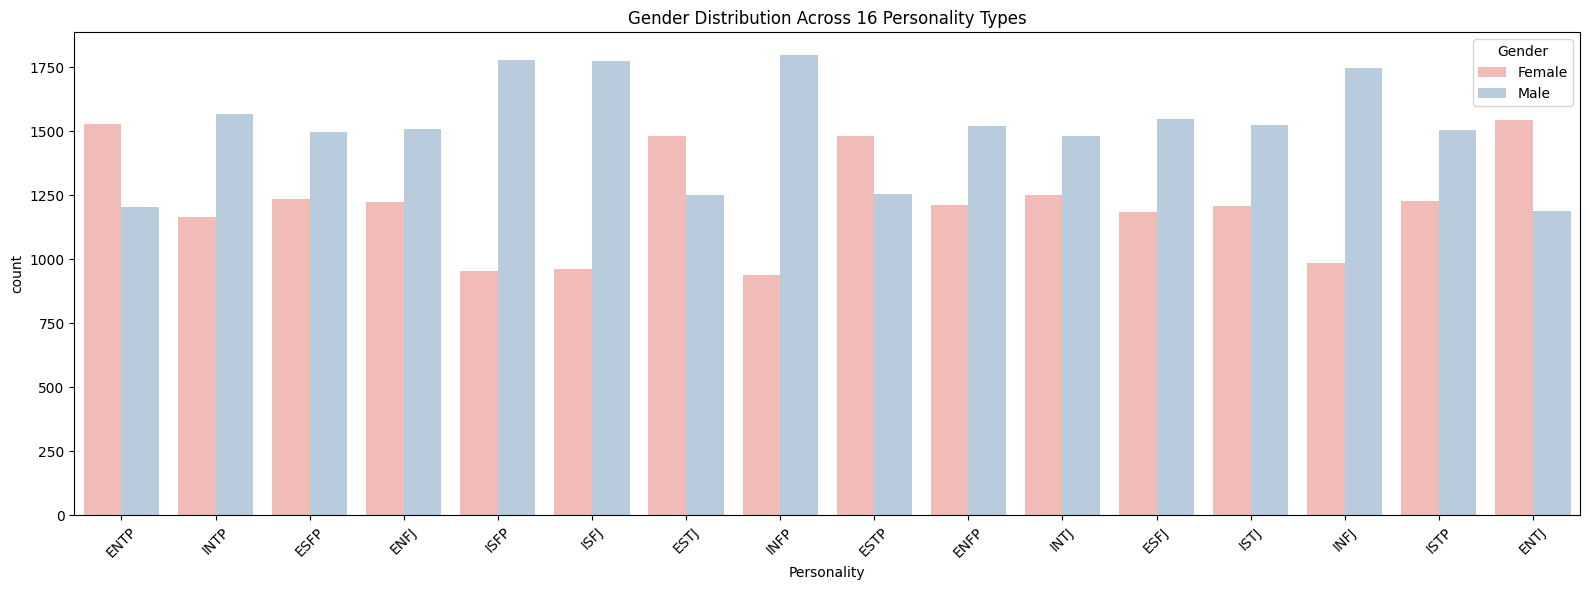

In [21]:
plt.figure(figsize=(16, 6))
sns.countplot(
    data=df,
    x="Personality",
    hue="Gender",
    # hue_order=["Male", "Female"],
    palette="Pastel1"
)

plt.xticks(rotation=45)
plt.title("Gender Distribution Across 16 Personality Types")
plt.tight_layout()
plt.show()

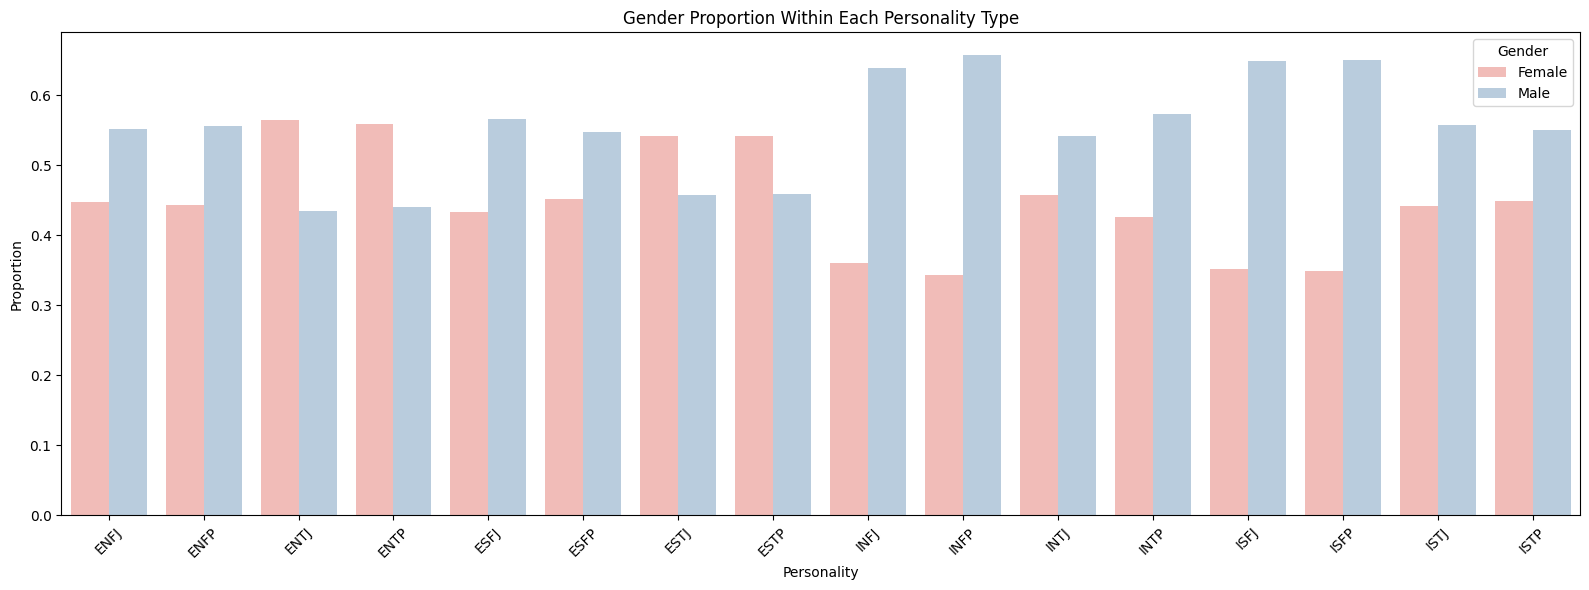

In [18]:
plt.figure(figsize=(16, 6))

percent_df = (
    df.groupby(["Personality", "Gender"])
      .size()
      .div(df.groupby("Personality").size()) 
      .reset_index(name="Proportion")
)

sns.barplot(
    data=percent_df,
    x="Personality",
    y="Proportion",
    hue="Gender",
    # hue_order=["Male", "Female"],
    palette="Pastel1"
)

plt.xticks(rotation=45)
plt.title("Gender Proportion Within Each Personality Type")
plt.tight_layout()
plt.show()


In [22]:
pd.crosstab(df["Personality"], df["Gender"], normalize="index") * 100

Gender,Female,Male
Personality,,
ENFJ,44.806145,55.193855
ENFP,44.403804,55.596196
ENTJ,56.510607,43.489393
ENTP,55.888808,44.111192
ESFJ,43.379663,56.620337
ESFP,45.245062,54.754938
ESTJ,54.242868,45.757132
ESTP,54.133138,45.866862
INFJ,36.027798,63.972202


### Education

In [23]:
ct_edu = pd.crosstab(df["Education"], df["Personality"])
ct_edu

Personality,ENFJ,ENFP,ENTJ,ENTP,ESFJ,ESFP,ESTJ,ESTP,INFJ,INFP,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP
Education,,,,,,,,,,,,,,,,
0,2733,1494,2730,1479,2732,1506,2733,1481,2731,1476,2732,1455,2730,1477,2727,1510
1,1,1240,4,1255,2,1228,1,1253,3,1258,2,1279,4,1257,7,1224


In [24]:
chi2, p, dof, expected = stats.chi2_contingency(ct_edu)

print("Chi-square:", chi2)
print("p-value:", p)
print("df:", dof)
print("Expected counts:\n", expected)

Chi-square: 12874.243196546164
p-value: 0.0
df: 15
Expected counts:
 [[2107.875 2107.875 2107.875 2107.875 2107.875 2107.875 2107.875 2107.875
  2107.875 2107.875 2107.875 2107.875 2107.875 2107.875 2107.875 2107.875]
 [ 626.125  626.125  626.125  626.125  626.125  626.125  626.125  626.125
   626.125  626.125  626.125  626.125  626.125  626.125  626.125  626.125]]


There is an extremely significant statistical association between education level and personality type, (Chi-square = 12874), with a p-value approaching zero. This indicates that the distribution of education levels is not uniform across personality types, with substantial differences in the prevalence of higher and lower education levels among different personality types. Under the assumption of independence, each personality type would be expected to exhibit a similar distribution of education levels; however, the observed frequencies deviate markedly from these expectations, providing further evidence of a strong association between education level and MBTI personality type.


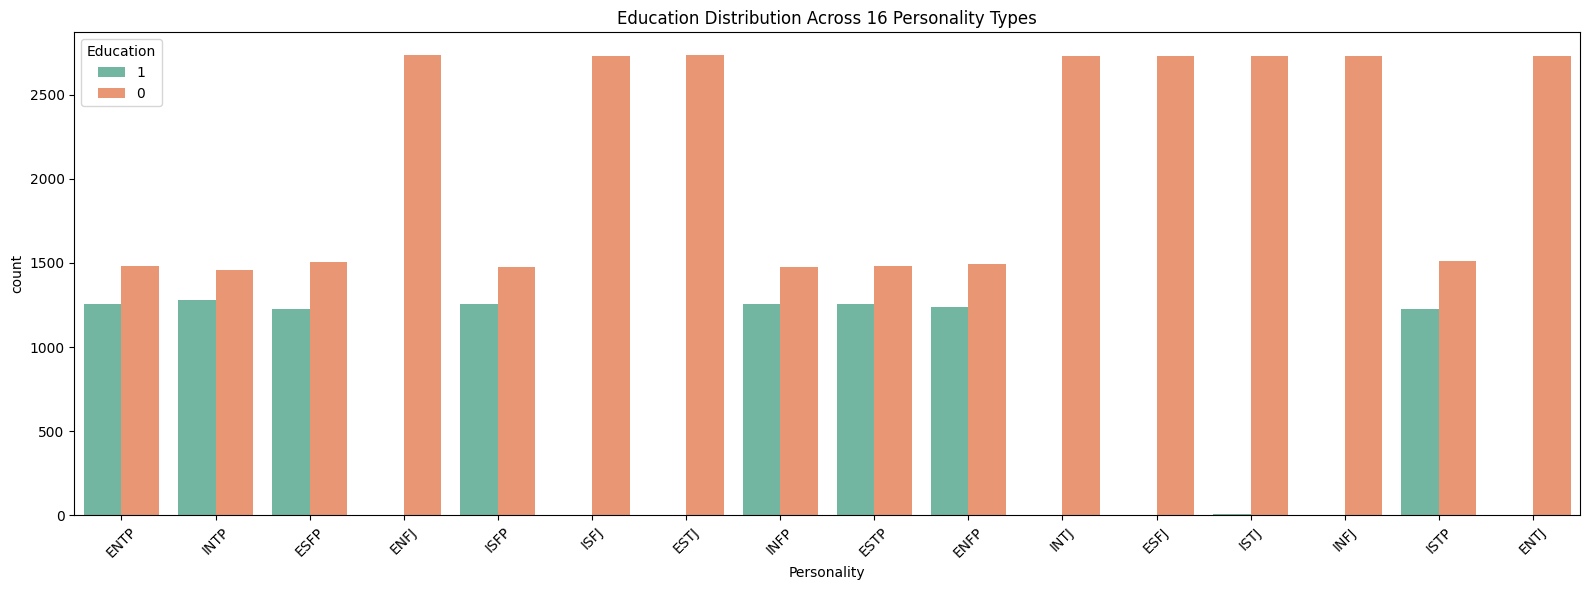

In [25]:
plt.figure(figsize=(16, 6))
sns.countplot(
    data=df,
    x="Personality",
    hue="Education",
    hue_order=[1, 0],  # 確保 1 = 高學歷 放前面
    palette="Set2"
)

plt.xticks(rotation=45)
plt.title("Education Distribution Across 16 Personality Types")
plt.tight_layout()
plt.show()

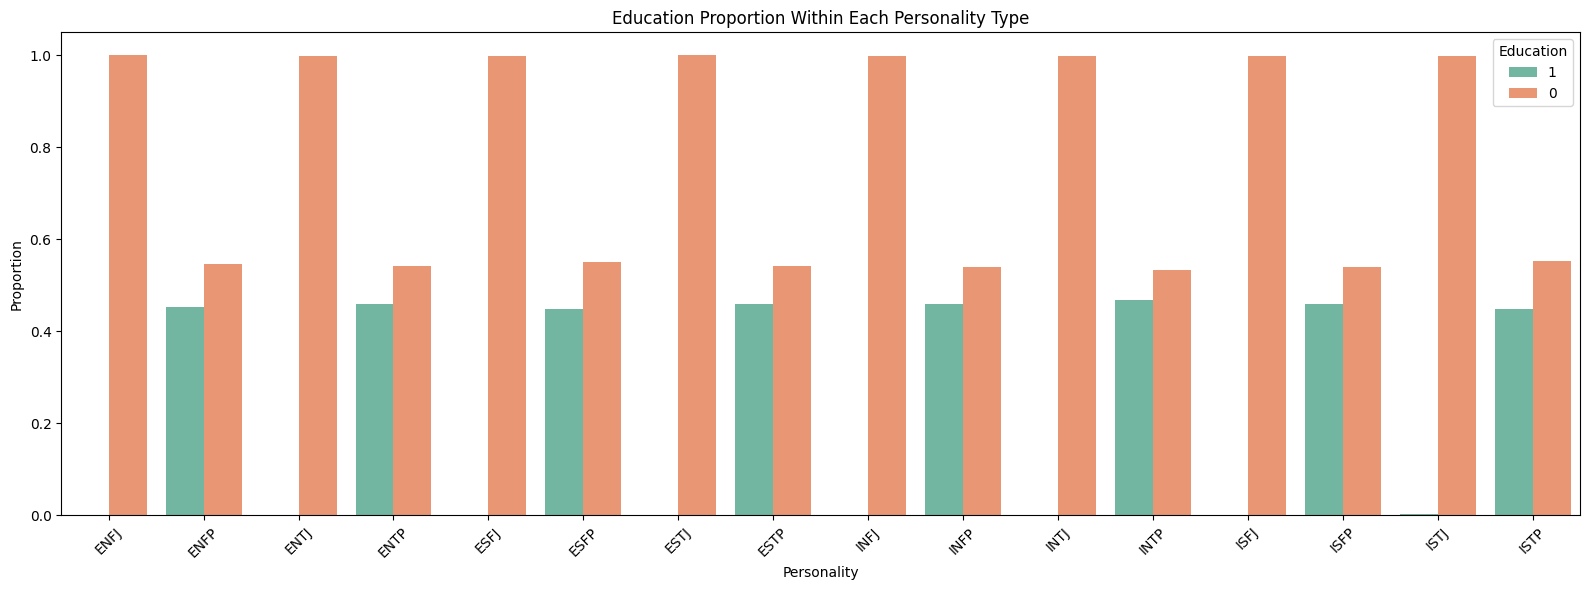

In [26]:
percent_edu = (
    df.groupby(["Personality", "Education"])
      .size()
      .div(df.groupby("Personality").size())
      .reset_index(name="Proportion")
)

plt.figure(figsize=(16, 6))
sns.barplot(
    data=percent_edu,
    x="Personality",
    y="Proportion",
    hue="Education",
    hue_order=[1, 0],
    palette="Set2"
)

plt.xticks(rotation=45)
plt.title("Education Proportion Within Each Personality Type")
plt.tight_layout()
plt.show()